In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
def group_f1_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    score = metrics.roc_auc_score(label, pred)
    return score

In [3]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    pred_b = softmax(pred_b)
    return pred_b[1] # the probability to greater label

## 1. Load the dataset

In [4]:
suppl = Chem.SDMolSupplier("../data/Chirality/chirbase_clean.sdf")
mols = [x for x in suppl if x is not None]

In [5]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

In [6]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [7]:
df_label

,SMILES,MB,K2/K1,Y
0,CCC(=O)O[C@@H](C)c1ccccc1,15,1.0100,0
1,CC(=O)O[C@@H](C)c1ccccc1,15,1.0300,0
2,O=C(O)[C@@H](Cl)c1ccccc1,15,1.0300,0
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2
4,COc1ccccc1[C@H](C)O,15,1.0400,0
...,...,...,...,...
76790,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,8,1.1843,2
76791,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,1.8069,2
76792,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,16,2.1600,3
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,5.0000,3


Keep the compounds have more than one CSP labeled

In [8]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()
df_label = df_label.groupby(['SMILES']).filter(lambda x: len(x) > 1) # labeled more than 1 CSP

In [9]:
df_label_all = df_label.copy()

Keep the largest K2/K1 of each compound as the best separatable mobile phase

In [10]:
df_label = df_label.sort_values(['SMILES', 'K2/K1'], ascending=False).drop_duplicates(['SMILES']).sort_index()

In [11]:
df_label

,SMILES,MB,K2/K1,Y
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2
23,c1ccc(CN2CCC[C@H]2c2cccnc2)cc1,15,1.1800,1
57,CN1C2CCC1CC(OC(=O)[C@H](O)c1ccccc1)C2,8,3.1300,3
59,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,8,1.2800,2
61,CN[C@H](C)Cc1ccccc1OC,8,1.4100,2
...,...,...,...,...
76718,COc1ccc2c(=O)c3cc(C(=O)N[C@@H](CO)C(C)C)ccc3oc2c1,11,10.5000,3
76726,COc1ccc2c(=O)c3cc(C(=O)N[C@H](C)CO)ccc3oc2c1,11,6.9400,3
76733,COc1ccc2c(=O)c3cc(C(=O)NC[C@@H](C)O)ccc3oc2c1,11,1.5100,2
76744,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2.0000,3


## 2. Load the prediction results

In [12]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
        
df_pred = pd.concat(dfs, ignore_index=True)

In [13]:
df_pred['Class_b'] = df_pred['Class'].apply(binary_cls)
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

Duplecated the SMILES and MB (keep largest probability)

In [14]:
df_pred = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()

In [15]:
df_pred

,SMILES,MB,Class,Pred,Class_b,Pred_b
0,CC(=O)C[C@H](C[N+](=O)[O-])c1ccc(Cl)cc1,0,1,"2.592926193756284e-07,0.9999926090240479,6.128...",0,0.268944
1,Cc1ccc2c(c1)[C@@](/C=C/C(=O)c1ccc(F)c(Oc3ccccc...,0,2,"7.336381457889729e-08,1.665817035245709e-05,0....",1,0.731052
3,Cc1cc(C)c(N2C(=O)C[C@H](CP(=O)(c3ccccc3C(F)(F)...,0,2,"0.000637401535641402,0.004572360310703516,0.98...",1,0.729005
4,COc1ccccc1[C@@H](O)C[N+](=O)[O-],0,1,"1.4940153050702065e-05,0.9990389347076416,0.00...",0,0.269314
5,CCOC(=O)C[C@H](Nc1ccc(OC)cc1)c1ccccc1C,0,2,"3.075223867199384e-05,8.774979505687952e-05,0....",1,0.731012
...,...,...,...,...,...,...
76686,COC(=O)[C@@H](O)c1ccccc1,17,0,"0.9879062175750732,1.967992830032017e-05,0.011...",0,0.273716
76692,COc1cc(N[C@@H](C)CCC(=O)O)c2ncccc2c1,17,2,"4.314469137511878e-08,5.592053184955148e-07,0....",1,0.731058
76695,C[C@H](O)c1ccccc1,17,0,"0.9181826114654541,0.0006034186226315796,0.071...",0,0.302046
76697,NC(=O)[C@@H]1CNCCN1,17,0,"0.9696916937828064,1.4468203062278917e-06,0.03...",0,0.281024


## ~~3. Unsolved compounds in all CSPs~~

In [16]:
df_label0 = df_label[(df_label['Y'] == 0) | (df_label['Y'] == 1)]

In [17]:
df_label0

,SMILES,MB,K2/K1,Y
23,c1ccc(CN2CCC[C@H]2c2cccnc2)cc1,15,1.1800,1
369,COC(=O)C(C)(C)[C@H]1CC(=O)N1,8,1.1300,1
446,O=C(O)[C@@H]1CC[C@H]1C(=O)O,8,1.1300,1
448,O=C(O)[C@@H]1CCCC[C@H]1C(=O)O,8,1.0800,1
765,COC(=O)[C@@H](C)Oc1cc(Cl)c(Cl)cc1Cl,7,1.1100,1
...,...,...,...,...
75748,COC(=O)C(C)(C(=O)OC)[C@@H]1C=CCCC1,14,1.1079,0
76065,COC(=O)[C@@](N)(c1ccccc1)C(F)(F)F,2,1.0000,0
76067,COC(=O)[C@@](N)(c1ccc(OC)cc1)C(F)(F)F,2,1.0000,0
76425,O=C(O)[C@@H](O)c1ccc2ccccc2c1O,8,1.0000,0


In [18]:
list_label0 = df_label0['SMILES'].tolist()

Keep the largest probability in prediction among all mobile phases as the hitten mobile phase

In [19]:
df_pred0 = df_pred.sort_values(['SMILES', 'Pred_b'], ascending=False).drop_duplicates(['SMILES']).sort_index()

In [20]:
df_pred0 = df_pred0[df_pred0['Pred_b'] < 0.5]

In [21]:
df_pred0

,SMILES,MB,Class,Pred,Class_b,Pred_b
7,CCCCCC[C@]1(C)C(=O)NC(=O)N(C)C1=O,0,1,"1.4001918316353112e-05,0.9974179267883301,0.00...",0,0.269952
26,CCOC(=O)C(C(=O)OCC)[C@@H](NS(=O)(=O)c1ccc(C)cc...,0,1,"3.649603740996099e-06,0.9947962164878845,0.005...",0,0.270991
27,CCCCOC(=O)[C@H](C)c1ccc(-c2ccccc2)c(F)c1,0,1,"1.6690107713657198e-06,0.9998935461044312,0.00...",0,0.268983
36,C[C@@H](C(=O)O)c1ccco1,0,1,"2.875504151234054e-06,0.9999690055847168,2.176...",0,0.268952
91,CCCCOC(=O)[C@@H](C)c1cccc(Oc2ccccc2)c1,0,1,"1.78843367848458e-06,0.9998002648353577,0.0001...",0,0.269019
...,...,...,...,...,...,...
76136,CC(=O)CC[C@H]1N=C(c2ccccc2)c2cc(Cl)ccc2N(C)C1=O,17,0,"0.9999020099639893,6.031956672813976e-06,6.482...",0,0.268978
76178,CC1=C2C(=O)c3c(O)cccc3C=C2C[C@H](CC(=O)O)O1,17,1,"0.8352458477020264,0.002005067653954029,0.1623...",0,0.337490
76279,C[C@@H](C(=O)OCCSCC(=O)NCCCOc1cccc(CN2CCCCC2)c...,17,0,"0.9997729659080505,2.8025300707668066e-05,0.00...",0,0.269020
76324,CC(=O)CC(=O)O[C@H]1N=C(c2ccccc2)c2cc(Cl)ccc2N(...,17,0,"0.9998373985290527,2.9364578040258493e-06,0.00...",0,0.269004


In [22]:
list_pred0 = df_pred0['SMILES'].tolist()

In [23]:
tn = sum([1 for p in list_label0 if p in list_pred0])

In [24]:
tn

307

In [25]:
fn = sum([1 for p in list_label0 if p not in list_pred0])

In [26]:
fn

176

In [27]:
len(list_label0)

483

In [28]:
len(list_pred0)

5841

## 4. Top-K 

In [29]:
def top_k(df):
    hitten_df = df.sort_values('Pred_b', ascending=False).reset_index(drop=True)
    data = {'SMILES': [hitten_df.loc[0, 'SMILES']], 
            'hitten_MB': [','.join(hitten_df['MB'].astype(str).tolist())], 
            'hitten_Prob': [','.join(hitten_df['Pred_b'].astype(str).tolist())]}
    return pd.DataFrame.from_dict(data)

def top_k_acc(hitten_mb, mb, k):
    if pd.isnull(hitten_mb): 
        return 0
    hitten_mb = hitten_mb.split(',')
    if mb in hitten_mb[:k]:
        return 1
    else:
        return 0

In [30]:
df_label1 = df_label[(df_label['Y'] == 2) | (df_label['Y'] == 3)]

df_pred1 = df_pred[df_pred['Class_b'] == 1]

df_topk = df_pred1.groupby('SMILES').apply(top_k).reset_index(drop=True)
df_topk = df_topk.merge(df_label1, how='right', on='SMILES')

In [31]:
df_topk

,SMILES,hitten_MB,hitten_Prob,MB,K2/K1,Y
0,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,0.2689414699766805,15,1.3100,2
1,CN1C2CCC1CC(OC(=O)[C@H](O)c1ccccc1)C2,NaN,NaN,8,3.1300,3
2,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,8,0.7310070802522458,8,1.2800,2
3,CN[C@H](C)Cc1ccccc1OC,"8,2","0.7310581087653861,0.269592742179257",8,1.4100,2
4,CCC[C@@H](C)NC(=O)c1ccccc1,10,0.7310583775593636,10,1.5300,2
...,...,...,...,...,...,...
3916,COc1ccc2c(=O)c3cc(C(=O)N[C@@H](CO)C(C)C)ccc3oc2c1,"11,12,2,3","0.731058577428633,0.7306937882900483,0.2831548...",11,10.5000,3
3917,COc1ccc2c(=O)c3cc(C(=O)N[C@H](C)CO)ccc3oc2c1,"11,12,2","0.7310585706199385,0.7310581331647277,0.731011...",11,6.9400,3
3918,COc1ccc2c(=O)c3cc(C(=O)NC[C@@H](C)O)ccc3oc2c1,11,0.7310585360251252,11,1.5100,2
3919,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,"6,13,11,12","0.7310582979791904,0.7310581291645515,0.731054...",13,2.0000,3


In [32]:
df_topk['top1_right'] = df_topk.apply(lambda x: top_k_acc(x['hitten_MB'], x['MB'], k=1), axis=1)
df_topk['top2_right'] = df_topk.apply(lambda x: top_k_acc(x['hitten_MB'], x['MB'], k=2), axis=1)
df_topk['top3_right'] = df_topk.apply(lambda x: top_k_acc(x['hitten_MB'], x['MB'], k=3), axis=1)

In [33]:
df_topk

,SMILES,hitten_MB,hitten_Prob,MB,K2/K1,Y,top1_right,top2_right,top3_right
0,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,0.2689414699766805,15,1.3100,2,1,1,1
1,CN1C2CCC1CC(OC(=O)[C@H](O)c1ccccc1)C2,NaN,NaN,8,3.1300,3,0,0,0
2,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,8,0.7310070802522458,8,1.2800,2,1,1,1
3,CN[C@H](C)Cc1ccccc1OC,"8,2","0.7310581087653861,0.269592742179257",8,1.4100,2,1,1,1
4,CCC[C@@H](C)NC(=O)c1ccccc1,10,0.7310583775593636,10,1.5300,2,1,1,1
...,...,...,...,...,...,...,...,...,...
3916,COc1ccc2c(=O)c3cc(C(=O)N[C@@H](CO)C(C)C)ccc3oc2c1,"11,12,2,3","0.731058577428633,0.7306937882900483,0.2831548...",11,10.5000,3,1,1,1
3917,COc1ccc2c(=O)c3cc(C(=O)N[C@H](C)CO)ccc3oc2c1,"11,12,2","0.7310585706199385,0.7310581331647277,0.731011...",11,6.9400,3,1,1,1
3918,COc1ccc2c(=O)c3cc(C(=O)NC[C@@H](C)O)ccc3oc2c1,11,0.7310585360251252,11,1.5100,2,1,1,1
3919,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,"6,13,11,12","0.7310582979791904,0.7310581291645515,0.731054...",13,2.0000,3,0,1,1


Plot!

In [34]:
top_k_avg_acc = [df_topk['top1_right'].sum()/len(df_topk), 
                 df_topk['top2_right'].sum()/len(df_topk), 
                 df_topk['top3_right'].sum()/len(df_topk)]
top_k_avg_plot = {'MB': ['Average']*3, 'Acc': top_k_avg_acc, 'K': [0, 1, 2]}
top_k_avg_plot = pd.DataFrame.from_dict(top_k_avg_plot)

In [35]:
dfs = []
for i in range(1, 4): 
    key = 'top{}_right'.format(str(i))
    df_tmp = df_topk.groupby('MB').apply(lambda df: df[key].sum()/len(df)).to_frame(name='Acc').reset_index()
    df_tmp['K'] = str(i)
    dfs.append(df_tmp)
    
df_topk_plot = pd.concat(dfs, ignore_index=True)

In [36]:
df_topk_plot[df_topk_plot['Acc']<0.8]

,MB,Acc,K
0,0,0.448276,1
1,1,0.254902,1
2,10,0.782805,1
3,11,0.636000,1
4,12,0.472222,1
5,13,0.629310,1
6,14,0.603774,1
7,15,0.571429,1
8,16,0.336957,1
9,17,0.428571,1


In [37]:
df_topk_plot['MB'] = df_topk_plot['MB'].astype(int)
MB_dict = {0: 'Chiralpak IB', 1: 'Chirobiotic TAG', 2: 'Chirobiotic T', 3: 'Chirobiotic V', 4: 'Whelk-O', 
           5: 'Cyclobond I RN', 6: 'Chiralcel OJ (Lux Cellulose-3)', 7: 'Pirkle (R or S)-DNBPG', 
           8: 'Chiralcel OD (Lux Cellulose-1)', 9: 'Chiralpak AS', 10: 'Chiralcel OB',
           11: 'Chiralpak AD', 12: 'Chirobiotic R', 13: 'Chiral-AGP', 14: 'Chiralpak IC (Sepapak 5)', 
           15: 'Cyclobond I', 16: 'Chiralpak IA', 17: 'Ultron-ES-OVM',}
df_topk_plot = df_topk_plot.sort_values(['K', 'Acc'], ascending=True)
df_topk_plot['CSP_Names'] = df_topk_plot['MB'].apply(lambda x: MB_dict[x])

In [38]:
order = []
order_re = []

tmp = df_topk_plot['CSP_Names'].tolist()
tmp.reverse()

for csp_name1, csp_name2 in zip(df_topk_plot['CSP_Names'].tolist(), tmp):
    if csp_name1 not in order:
        order.append(csp_name1)
    if csp_name2 not in order_re:
        order_re.append(csp_name2)

In [39]:
order

['Chirobiotic TAG',
 'Chirobiotic V',
 'Chiralpak IA',
 'Ultron-ES-OVM',
 'Chiralpak IB',
 'Chirobiotic R',
 'Cyclobond I',
 'Chiralcel OD (Lux Cellulose-1)',
 'Whelk-O',
 'Chiralpak IC (Sepapak 5)',
 'Cyclobond I RN',
 'Chiral-AGP',
 'Chiralpak AD',
 'Chiralcel OJ (Lux Cellulose-3)',
 'Chirobiotic T',
 'Chiralpak AS',
 'Chiralcel OB',
 'Pirkle (R or S)-DNBPG']

In [40]:
df_topk_plot

,MB,Acc,K,CSP_Names
1,1,0.254902,1,Chirobiotic TAG
11,3,0.333333,1,Chirobiotic V
8,16,0.336957,1,Chiralpak IA
9,17,0.428571,1,Ultron-ES-OVM
0,0,0.448276,1,Chiralpak IB
4,12,0.472222,1,Chirobiotic R
7,15,0.571429,1,Cyclobond I
16,8,0.588517,1,Chiralcel OD (Lux Cellulose-1)
12,4,0.596386,1,Whelk-O
6,14,0.603774,1,Chiralpak IC (Sepapak 5)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


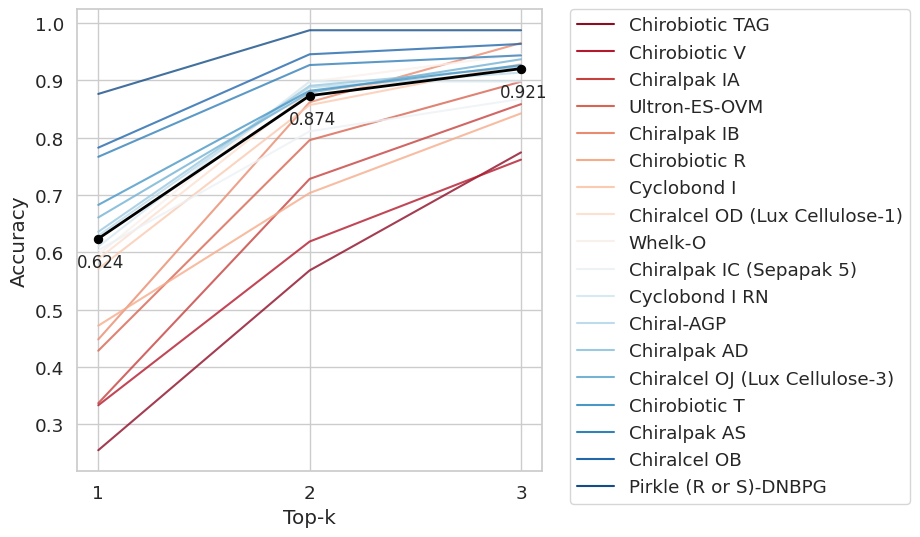

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
sns.set_style("whitegrid")



fig, ax = plt.subplots(figsize=(6, 6))

sns.lineplot(data=df_topk_plot, x="K", y="Acc", hue="CSP_Names", hue_order=order, 
             ax=ax, 
             # legend=False, 
             # palette=['lightgray']*18,
             palette="RdBu", alpha=0.8, 
            )

sns.lineplot(data=top_k_avg_plot, x="K", y="Acc", hue="MB", 
             ax=ax, 
             legend=False, 
             style='MB', markers='o', markersize=6, markeredgecolor='black', 
             linewidth=2, 
             palette=['black'], alpha=1)
for idx, row in top_k_avg_plot.iterrows(): 
    x = row['K']
    y = row['Acc']
    ax.text(x-0.1, y-0.05, f'{y:.3f}', fontsize=12)
    
plt.legend(bbox_to_anchor=(1.06, 1), ncol=1, loc='upper left', borderaxespad=0)
ax.set(xlabel='Top-k', ylabel='Accuracy')

plt.savefig('./best_csp_topk_acc.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./best_csp_topk_acc.png', dpi=600, bbox_inches='tight')
plt.show()

In [42]:
df_cnt = df_label_all.groupby('MB').size().to_frame(name='Compound_Number')
df_cnt.reset_index(inplace=True)
df_cnt = df_cnt.rename(columns = {'index': 'MB'})

df_cnt['MB'] = df_cnt['MB'].astype(int)
df_cnt['CSP_Names'] = df_cnt['MB'].apply(lambda x: MB_dict[x])

In [43]:
df_cnt

,MB,Compound_Number,CSP_Names
0,0,273,Chiralpak IB
1,1,290,Chirobiotic TAG
2,10,569,Chiralcel OB
3,11,2288,Chiralpak AD
4,12,380,Chirobiotic R
5,13,354,Chiral-AGP
6,14,223,Chiralpak IC (Sepapak 5)
7,15,379,Cyclobond I
8,16,422,Chiralpak IA
9,17,136,Ultron-ES-OVM


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


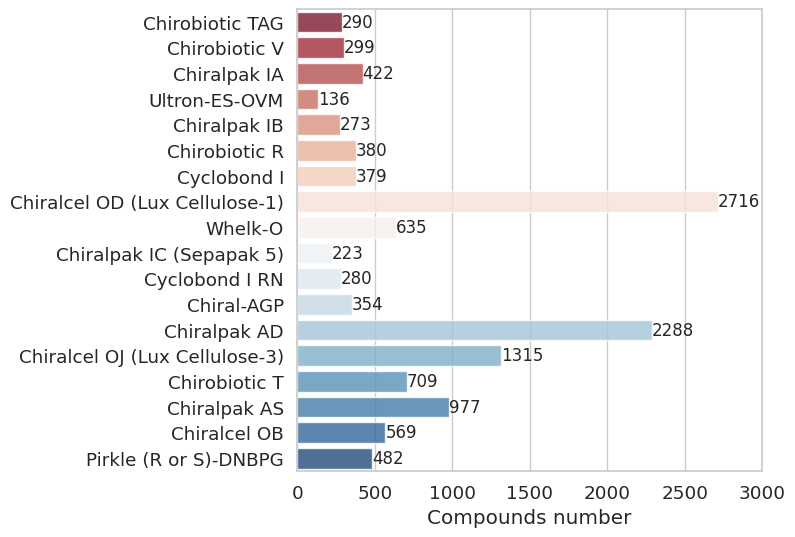

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
sns.barplot(x=df_cnt['Compound_Number'], y=df_cnt['CSP_Names'], ax=ax, 
            orient='h', order=order, 
            ci=None,
            palette="RdBu", alpha=0.8, )
for i in ax.containers:
    ax.bar_label(i, size=12)
    
ax.set(xlabel='Compounds number', ylabel='', xlim=(0, 3000))

plt.savefig('./best_csp_stat.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./best_csp_stat.png', dpi=600, bbox_inches='tight')
plt.show()

e.g. 

In [45]:
g = df_pred.groupby('SMILES')
size = g.size()

In [46]:
size[size > 3]

SMILES
C#C[C@H](O)c1ccccc1                   7
C1CCN(C[C@@H]2CO2)C1                  4
C1CCN(C[C@@H]2CO2)CC1                 4
C1CN(C[C@@H]2CO2)CCO1                 4
C=C(C)C(=O)OC[C@H]1CO1                4
                                     ..
c1ccc2c(c1)CCC[C@@H]2C1=NCCN1         5
c1ccc2c(c1)CCC[C@@H]2Cc1ccncc1        4
c1ccc2c(c1)CCc1ccccc1N2C[C@@H]1CO1    4
c1ccc2c(c1)C[C@H]2Cn1ccnc1            4
c1ccc2c(c1)Sc1ccccc1N2C[C@@H]1CO1     4
Length: 865, dtype: int64

In [47]:
df_pred[df_pred['SMILES'] == 'C#C[C@H](O)c1ccccc1']

,SMILES,MB,Class,Pred,Class_b,Pred_b
377,C#C[C@H](O)c1ccccc1,0,2,"1.3083875671782152e-07,3.4174943266407354e-06,...",1,0.731057
13871,C#C[C@H](O)c1ccccc1,6,2,"3.2497760038552315e-09,1.4632153977345297e-07,...",1,0.731059
28014,C#C[C@H](O)c1ccccc1,8,2,"2.486357004727324e-07,9.078250968741486e-07,0....",1,0.731058
48986,C#C[C@H](O)c1ccccc1,10,2,"3.2148986250923883e-10,2.3288858841397087e-08,...",1,0.731059
60024,C#C[C@H](O)c1ccccc1,11,1,"7.246130735438783e-06,0.9999303817749023,4.897...",0,0.268966
71708,C#C[C@H](O)c1ccccc1,14,1,"6.421529974431905e-07,0.9998862743377686,0.000...",0,0.268986
74229,C#C[C@H](O)c1ccccc1,16,0,"0.9999946355819702,5.653494099533418e-07,4.585...",0,0.268943


In [48]:
df_label_all[df_label_all['SMILES'] == 'C#C[C@H](O)c1ccccc1']

,SMILES,MB,K2/K1,Y
301,C#C[C@H](O)c1ccccc1,10,1.20,2
32702,C#C[C@H](O)c1ccccc1,8,1.73,2
32703,C#C[C@H](O)c1ccccc1,11,1.14,1
35859,C#C[C@H](O)c1ccccc1,6,1.86,2
46344,C#C[C@H](O)c1ccccc1,14,1.15,1
59239,C#C[C@H](O)c1ccccc1,0,1.37,2
59413,C#C[C@H](O)c1ccccc1,16,1.10,0
